In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
%matplotlib inline

In [3]:
data = pd.read_csv('Time_series/sp500_index.csv')
data.head()

,Date,S&P500
0,2014-10-17,1886.76
1,2014-10-20,1904.01
2,2014-10-21,1941.28
3,2014-10-22,1927.11
4,2014-10-23,1950.82


In [4]:
data['Date'] = pd.to_datetime(data['Date'])

#data = data[(data['Date'].dt.year >= 2020) & (data['Date'].dt.year <= 2024)]

In [5]:
print(data.shape)
print(data.dtypes)

(2516, 2)
Date      datetime64[ns]
S&P500           float64
dtype: object


In [6]:
data.isnull().values.any()

False

In [7]:
data.describe()

,Date,S&P500
count,2516,2516.000000
mean,2019-10-17 07:17:50.270270208,3275.335537
min,2014-10-17 00:00:00,1829.080000
25%,2017-04-18 18:00:00,2373.470000
50%,2019-10-16 12:00:00,2945.495000
75%,2022-04-15 00:00:00,4154.607500
max,2024-10-16 00:00:00,5859.850000
std,NaN,1032.744674


### Exploratory Data Analysis

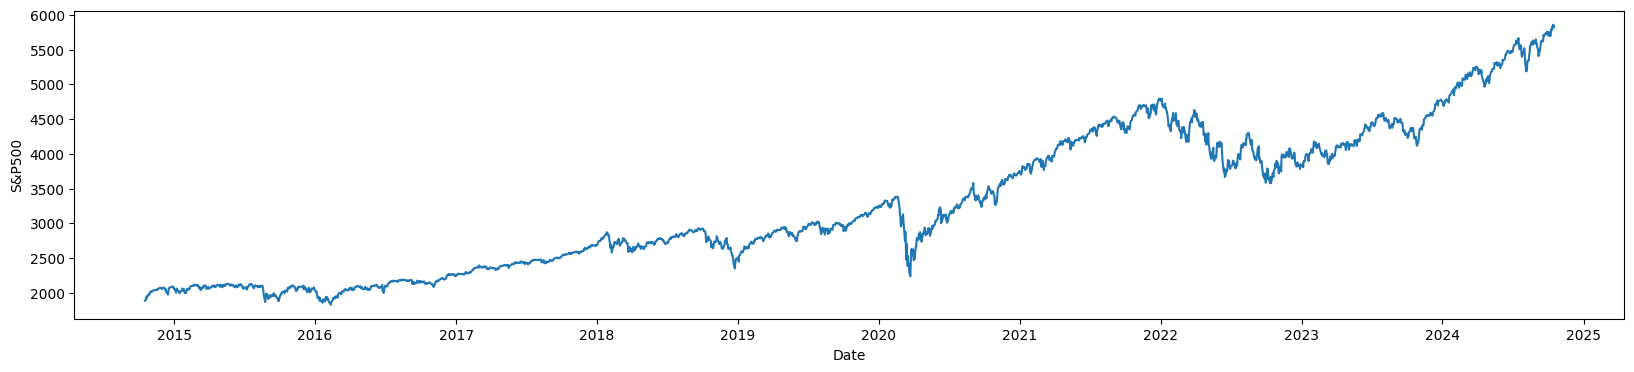

In [8]:
# plot car count over all years
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])
plt.show()

Abbiamo osservato che nel 2020 c'è un forte picco verso il basso che altera la tendenza nei dati. Analizziamo successivamente in dettaglio cosa succede

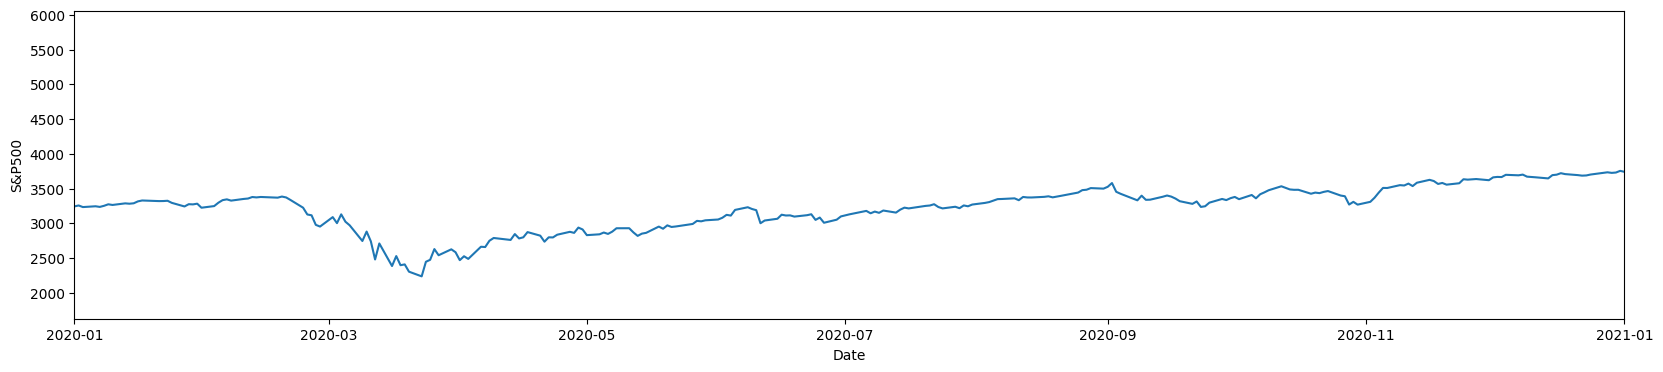

In [8]:
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2021,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])

Si può notare che il grande picco verso il basso si può ricollegare all'inizio del COVID, nei mesi di marzo aprile 2020. Successivamente si nota una graduale ripresa

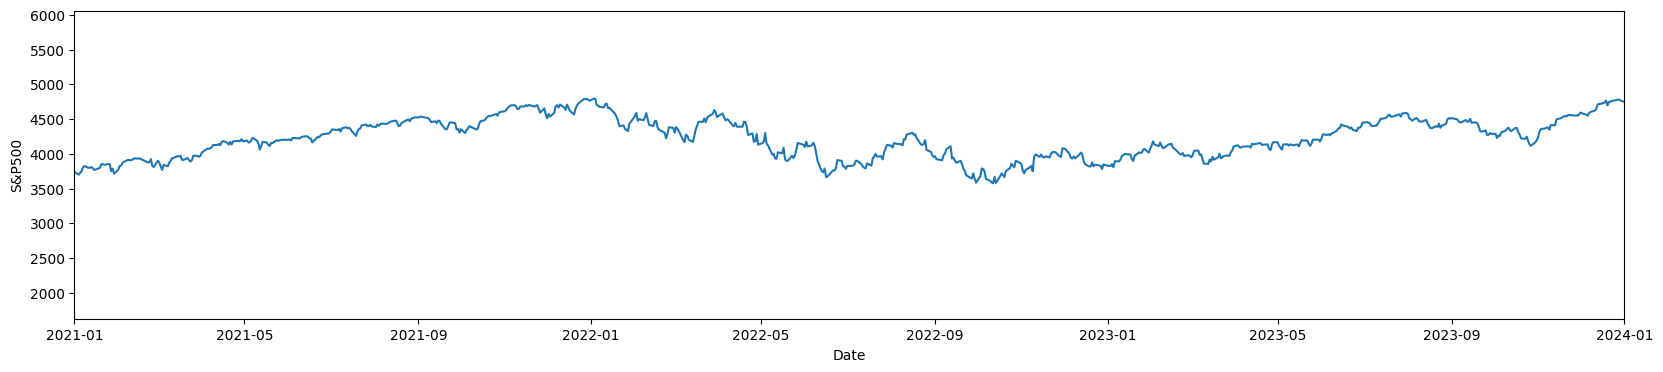

In [9]:
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2024,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])

un altro momento di picco verso il basso si ha ad inizio 2022 fino al 2023, ricollegabile alla difficile situazione geopolitica tra russia e ucraina

In [10]:
# Rimuovi i dati dal 2020-01-01 al 2020-05-31
#data_filter = data[~((data['Date'] >= '2020-01-01') & (data['Date'] <= '2020-05-31'))]

# Rimuovi dati da anni precedenti al 2022 o successivi al 2023
#data_new = data_filter[~((data_filter['Date'] >= '2022-01-01') & (data_filter['Date'] <= '2023-01-01'))]

data_new = data

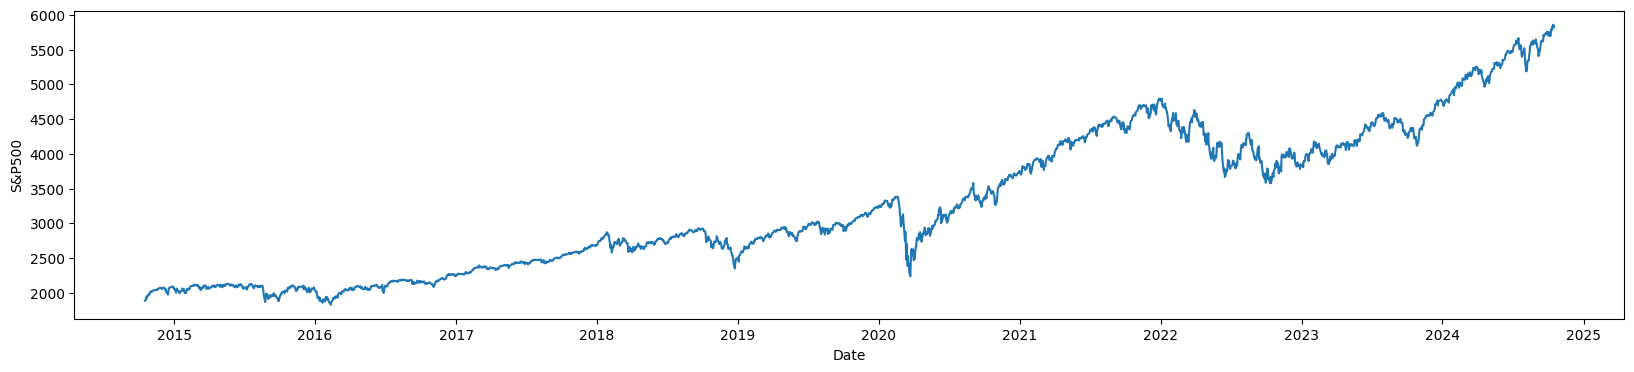

In [11]:
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data_new['Date'], data_new['S&P500'])
plt.show()

#### Suddivisione dataset training-test 80/20

In [9]:
# Ordina il DataFrame per la colonna Date
df_data = data.sort_values(by='Date')

# Trova la data di cutoff per gli ultimi 21 giorni
cutoff_date = df_data['Date'].max() - pd.Timedelta(days=300)

# Crea il DataFrame train e test
train_data = df_data[df_data['Date'] <= cutoff_date]
test_data = df_data[df_data['Date'] > cutoff_date]

# Stampa o verifica i DataFrame
print("Train DataFrame:")
print(train_data.head())

print("\nTest DataFrame:")
print(test_data.head())
print(f"Lughezza test: {len(test_data)}")
print(f"Lughezza train: {len(train_data)}")
print(f"Lunghezza totale: {len(df_data)}")

Train DataFrame:
        Date   S&P500
0 2014-10-17  1886.76
1 2014-10-20  1904.01
2 2014-10-21  1941.28
3 2014-10-22  1927.11
4 2014-10-23  1950.82

Test DataFrame:
           Date   S&P500
2311 2023-12-22  4754.63
2312 2023-12-26  4774.75
2313 2023-12-27  4781.58
2314 2023-12-28  4783.35
2315 2023-12-29  4769.83
Lughezza test: 205
Lughezza train: 2311
Lunghezza totale: 2516


## Forecasting

### Stationarity

In [10]:
def test_stationarity(ts):
    stats = ['Test Statistic', 'p-value']
    # Applica il test di Dickey-Fuller aumentato
    df_test = adfuller(ts.dropna())  # Rimuovi i NaN per evitare errori
    df_results = pd.Series(df_test[0:2], index=stats)
    
    print('ADF statistic:', df_results.iloc[0])
    print('P-value:', df_results.iloc[1])
    
    if df_results.iloc[1] <= 0.05:
        print("La serie è stazionaria (rifiutiamo H0).")
    else:
        print("La serie non è stazionaria (non rifiutiamo H0).")

In [11]:
test_stationarity(train_data['S&P500'])

ADF statistic: -0.38166902842657585
P-value: 0.9131146972798841
La serie non è stazionaria (non rifiutiamo H0).


Questo valore è molto alto, vicino a 1.
Un valore p così elevato indica che non hai evidenza sufficiente per rifiutare l'ipotesi nulla (H₀), che afferma che la serie non è stazionaria. Quindi serie non stazionaria (media, varianza o covarianza variano nel tempo). Per renderla stazonaria applicando le differenze ecc.

In [12]:
train_data['S&P500_diff'] = train_data['S&P500'].diff()
train_data['S&P500_diff'].head()

C:\Users\gians_ji5genm\AppData\Local\Temp\ipykernel_23252\693865438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['S&P500_diff'] = train_data['S&P500'].diff()


0      NaN
1    17.25
2    37.27
3   -14.17
4    23.71
Name: S&P500_diff, dtype: float64

In [13]:
test_stationarity(train_data['S&P500_diff'])

ADF statistic: -15.03907313594543
P-value: 9.652419896310735e-28
La serie è stazionaria (rifiutiamo H0).


Questo valore di ADF è ora molto negativo, il che suggerisce una forte evidenza contro l'ipotesi nulla (H₀). Un p-value così basso conferma che possiamo rifiutare l'ipotesi nulla (H₀) con grande confidenza. Concludiamo quindi che la serie è stazionaria dopo la differenziazione.

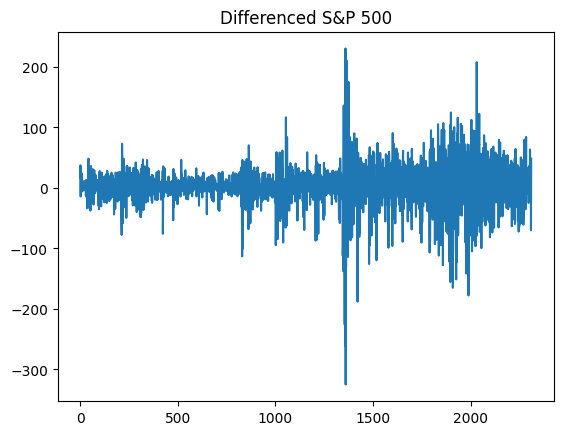

In [17]:
import matplotlib.pyplot as plt
train_data['S&P500_diff'].dropna().plot(title="Differenced S&P 500")
plt.show()

### ACF and PACF graphs

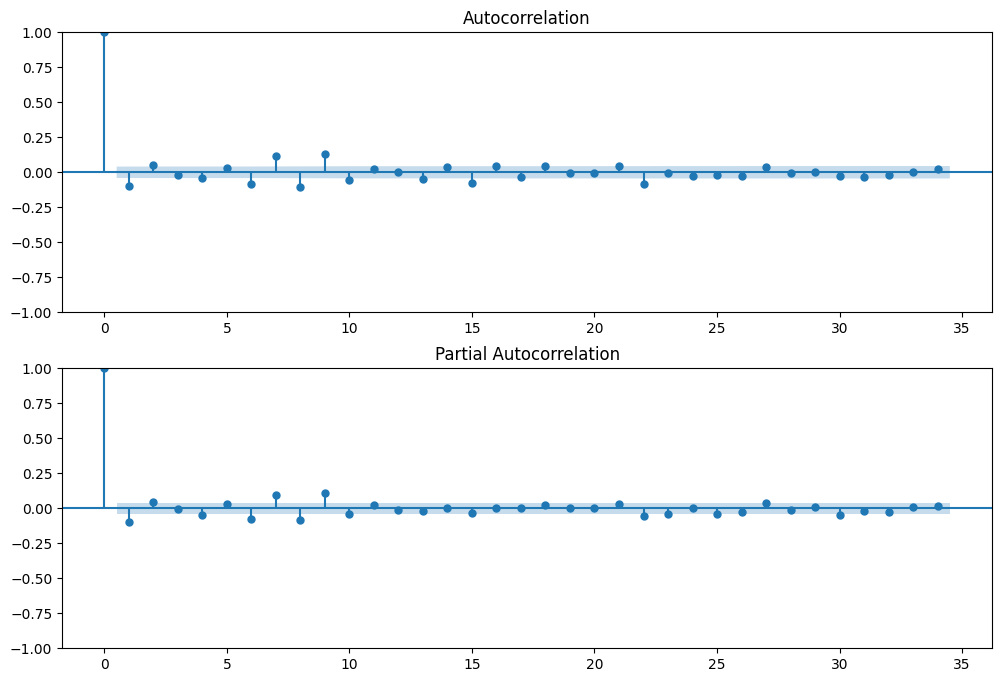

In [18]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data['S&P500_diff'][1:],  ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data['S&P500_diff'][1:], ax=ax2)

Possiamo notare una stagionalità intorno ai valori 6/8, quindi quei valori sono correlati con quelli dei 6/8 giorni precedenti (dipendo da quelli)

Primo valore 1 in entrambi perché Il primo lag (ritardo 0) di entrambe le funzioni mostra la correlazione della serie con sé stessa, che è sempre 1 (ovvero perfettamente correlata). Tutti gli altri valori sono prossimi allo zero, Questo comportamento suggerisce che la serie differenziata è quasi rumore bianco:
Un rumore bianco non ha una struttura prevedibile, il che significa che i valori futuri non dipendono linearmente dai valori passati. Possiamo provare quindi un ARIMA con d=1, p=0 (AR) e q=0 (MA).
- (0,1,0) 
- Auto_Arima (2,1,2)

In [16]:
train_data_dropped = train_data.drop('S&P500', axis=1)
train_data_dropped.describe()

,Date,S&P500_diff
count,2311,2310.000000
mean,2019-05-21 10:05:02.206836736,1.238091
min,2014-10-17 00:00:00,-324.890000
25%,2017-02-02 12:00:00,-11.645000
50%,2019-05-22 00:00:00,1.560000
75%,2021-09-05 00:00:00,17.235000
max,2023-12-21 00:00:00,230.380000
std,NaN,36.319271


In [17]:
test_stationarity(train_data_dropped['S&P500_diff'])

ADF statistic: -15.03907313594543
P-value: 9.652419896310735e-28
La serie è stazionaria (rifiutiamo H0).


In [18]:
train_data_dropped = train_data_dropped.dropna(subset=['S&P500_diff'])

print("\nDataFrame dopo aver eliminato le righe con 'Col1' nullo:")
print(train_data_dropped)


DataFrame dopo aver eliminato le righe con 'Col1' nullo:
           Date  S&P500_diff
1    2014-10-20        17.25
2    2014-10-21        37.27
3    2014-10-22       -14.17
4    2014-10-23        23.71
5    2014-10-24        13.76
...         ...          ...
2306 2023-12-15        -0.36
2307 2023-12-18        21.37
2308 2023-12-19        27.81
2309 2023-12-20       -70.02
2310 2023-12-21        48.40

[2310 rows x 2 columns]


### Fitting Model

In [19]:
# Modello ARIMA
model = ARIMA(train_data_dropped['S&P500_diff'], order=(1, 1, 1))
results_base = model.fit()

# Sommario del modello
print(results_base.summary())

c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            S&P500_diff   No. Observations:                 2310
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11564.372
Date:                Wed, 27 Nov 2024   AIC                          23134.743
Time:                        14:07:52   BIC                          23151.977
Sample:                             0   HQIC                         23141.025
                               - 2310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0955      0.010     -9.613      0.000      -0.115      -0.076
ma.L1         -1.0000      0.040    -24.702      0.000      -1.079      -0.921
sigma2      1307.1072     55.624     23.499      0.0

c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


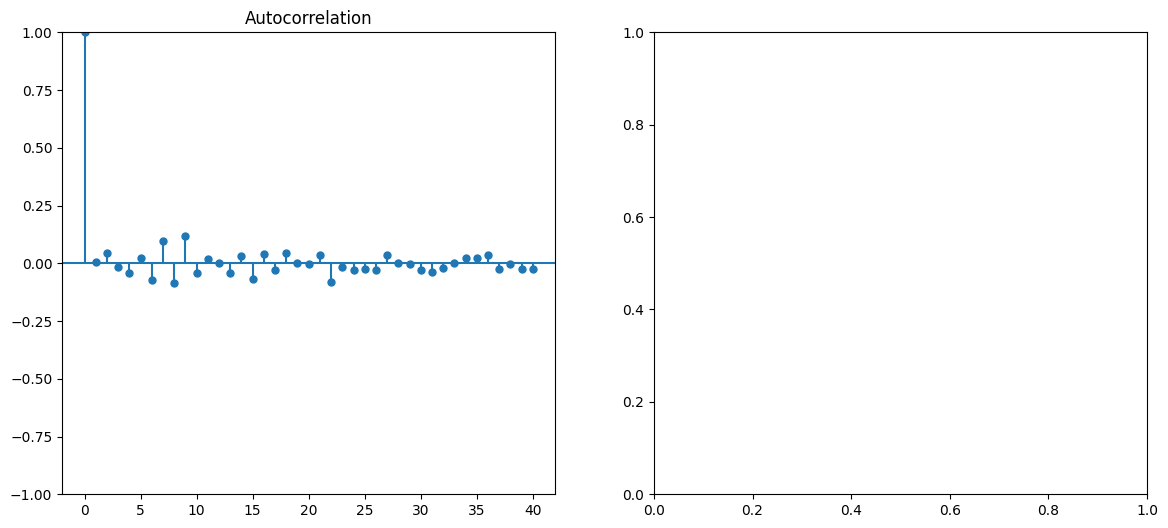

<Figure size 640x480 with 0 Axes>

In [20]:
# Previsione dei residui
from pmdarima import plot_acf, plot_pacf


residuals = results_base.resid

# Creazione dei grafici ACF e PACF dei residui
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF: Autocorrelation Function
plot_acf(residuals, ax=axes[0], lags=40)  # Lags=40 per osservare la correlazione a lungo termine
axes[0].set_title('Autocorrelation Function (ACF) dei Residui')

# PACF: Partial Autocorrelation Function
plot_pacf(residuals, ax=axes[1], lags=40)  # Lags=40 per osservare la correlazione parziale
axes[1].set_title('Partial Autocorrelation Function (PACF) dei Residui')

plt.tight_layout()
plt.show()

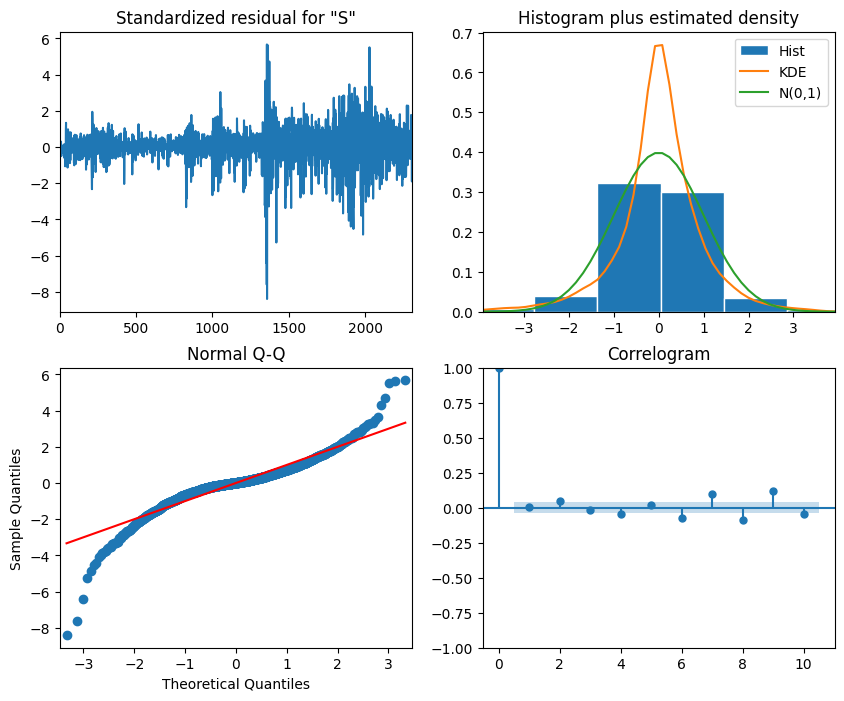

In [21]:
results_base.plot_diagnostics(figsize=(10, 8))
plt.show()

### Test di Ljun-Box sui residui

In [22]:
# Test di Ljung-Box sui residui
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Risultati del test di Ljung-Box:")
print(lb_test)

Risultati del test di Ljung-Box:
       lb_stat     lb_pvalue
10   96.734030  2.449661e-16
20  125.079668  3.244266e-17
30  154.305899  1.150586e-18


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Trova automaticamente il miglior modello SARIMA con auto_arima
#model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True)
model = auto_arima(train_data_dropped['S&P500_diff'], seasonal=True,m=22, stepwise=True, trace=True)

# Stampa i parametri del miglior modello trovato
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[22] intercept   : AIC=23047.683, Time=31.81 sec
 ARIMA(0,0,0)(0,0,0)[22] intercept   : AIC=23155.146, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[22] intercept   : AIC=23122.220, Time=3.86 sec
 ARIMA(0,0,1)(0,0,1)[22] intercept   : AIC=23123.569, Time=4.19 sec
 ARIMA(0,0,0)(0,0,0)[22]             : AIC=23155.830, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[22] intercept   : AIC=23045.289, Time=31.71 sec
 ARIMA(2,0,2)(0,0,0)[22] intercept   : AIC=23056.923, Time=8.09 sec


c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            S&P500_diff   No. Observations:                 2310
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -11522.462
Date:                Wed, 27 Nov 2024   AIC                          23056.923
Time:                        14:08:14   BIC                          23091.393
Sample:                             0   HQIC                         23069.488
                               - 2310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2345      0.730      1.690      0.091      -0.197       2.666
ar.L1         -1.7629      0.018    -97.352      0.000      -1.798      -1.727
ar.L2         -0.8864      0.017    -52.219      0.0

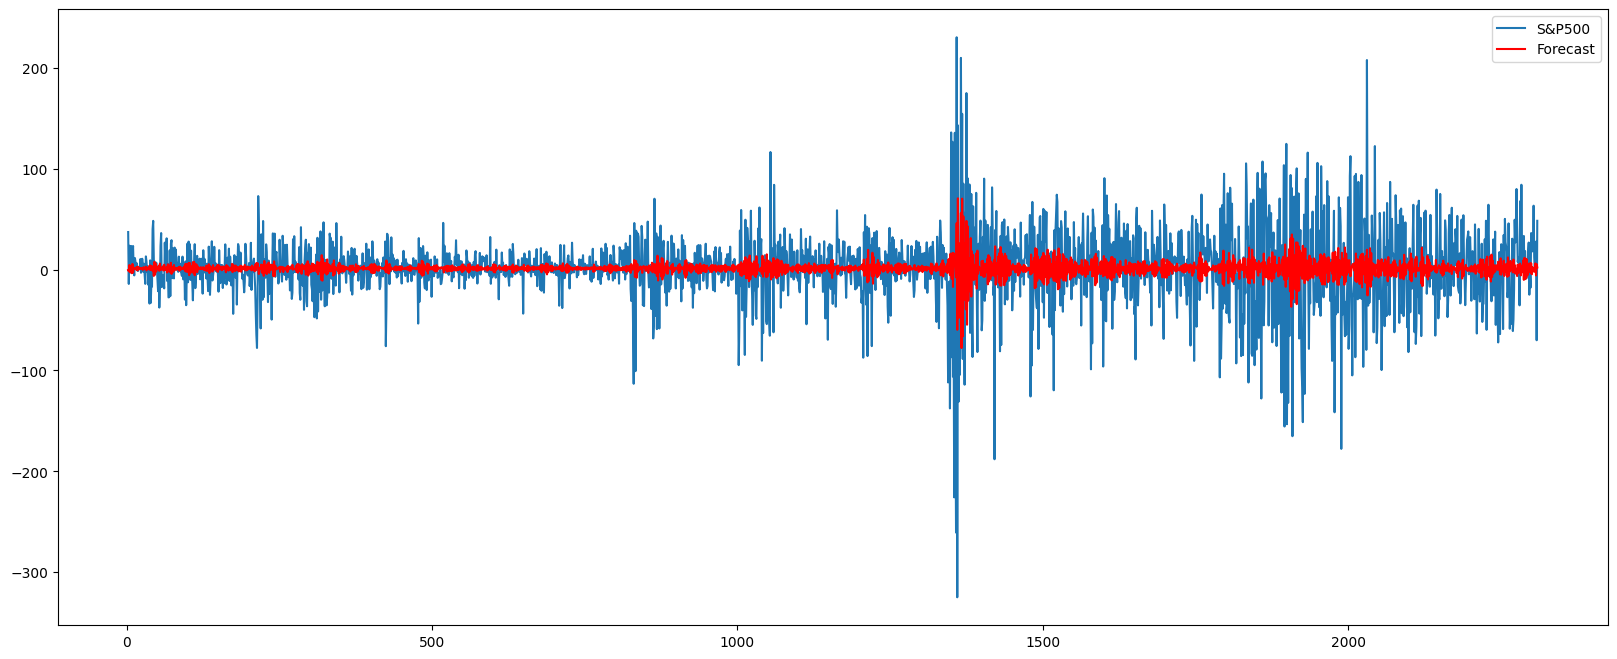

In [23]:
# Fit del modello SARIMA con i parametri trovati da auto_arima
model = ARIMA(train_data_dropped['S&P500_diff'], order=(2,0,2))
results = model.fit()

# Visualizza il grafico
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(train_data_dropped['S&P500_diff'][1:])
plt.plot(results.fittedvalues[1:], color='red')
ax.legend(['S&P500', 'Forecast'])

# Mostra il sommario dei risultati
print(results.summary())

c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


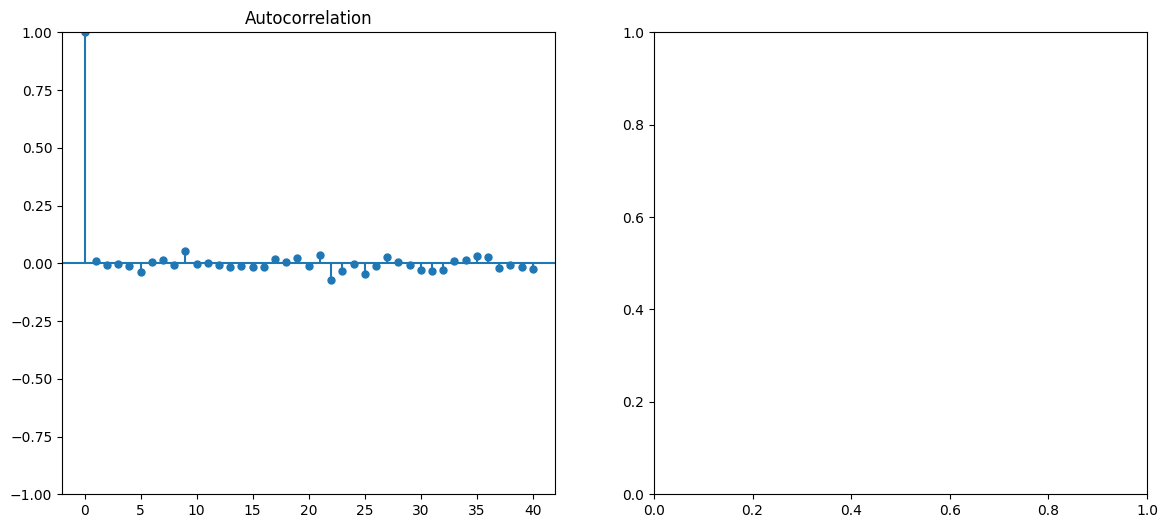

<Figure size 640x480 with 0 Axes>

In [24]:
# Previsione dei residui
residuals = results.resid

# Creazione dei grafici ACF e PACF dei residui
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF: Autocorrelation Function
plot_acf(residuals, ax=axes[0], lags=40)  # Lags=40 per osservare la correlazione a lungo termine
axes[0].set_title('Autocorrelation Function (ACF) dei Residui')

# PACF: Partial Autocorrelation Function
plot_pacf(residuals, ax=axes[1], lags=40)  # Lags=40 per osservare la correlazione parziale
axes[1].set_title('Partial Autocorrelation Function (PACF) dei Residui')

plt.tight_layout()
plt.show()

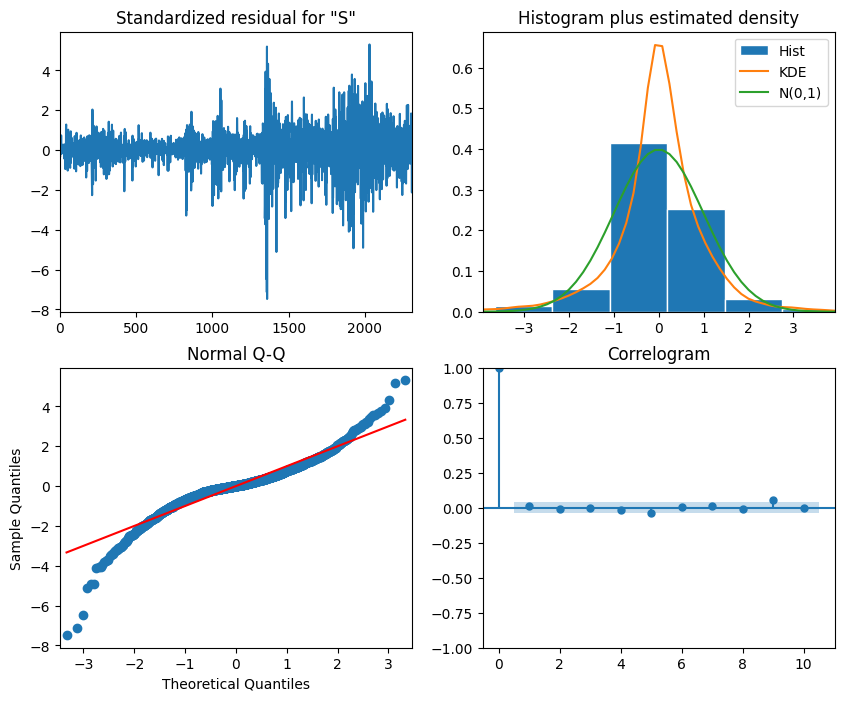

In [25]:
results.plot_diagnostics(figsize=(10, 8))
plt.show()

### Test di Ljung-Box

In [26]:
# Test di Ljung-Box sui residui
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Risultati del test di Ljung-Box:")
print(lb_test)

Risultati del test di Ljung-Box:
      lb_stat  lb_pvalue
10  11.382182   0.328528
20  16.215106   0.703193
30  44.416037   0.043705


I valori di p-value sopra la soglia di 0.05 indicano che i residui non mostrano correlazioni significative e inoltre indica che il modello ha catturato le principali dinamiche della serie temporale. In linea con i risultati di ACF e PACF vicini allo zero.

c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\

                                         SARIMAX Results                                         
Dep. Variable:                               S&P500_diff   No. Observations:                 2310
Model:             SARIMAX(10, 0, 10)x(2, 0, [1, 2], 22)   Log Likelihood              -11509.291
Date:                                   Wed, 27 Nov 2024   AIC                          23072.582
Time:                                           14:30:00   BIC                          23227.697
Sample:                                                0   HQIC                         23129.123
                                                  - 2310                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4738      5.254      0.090      0.928    

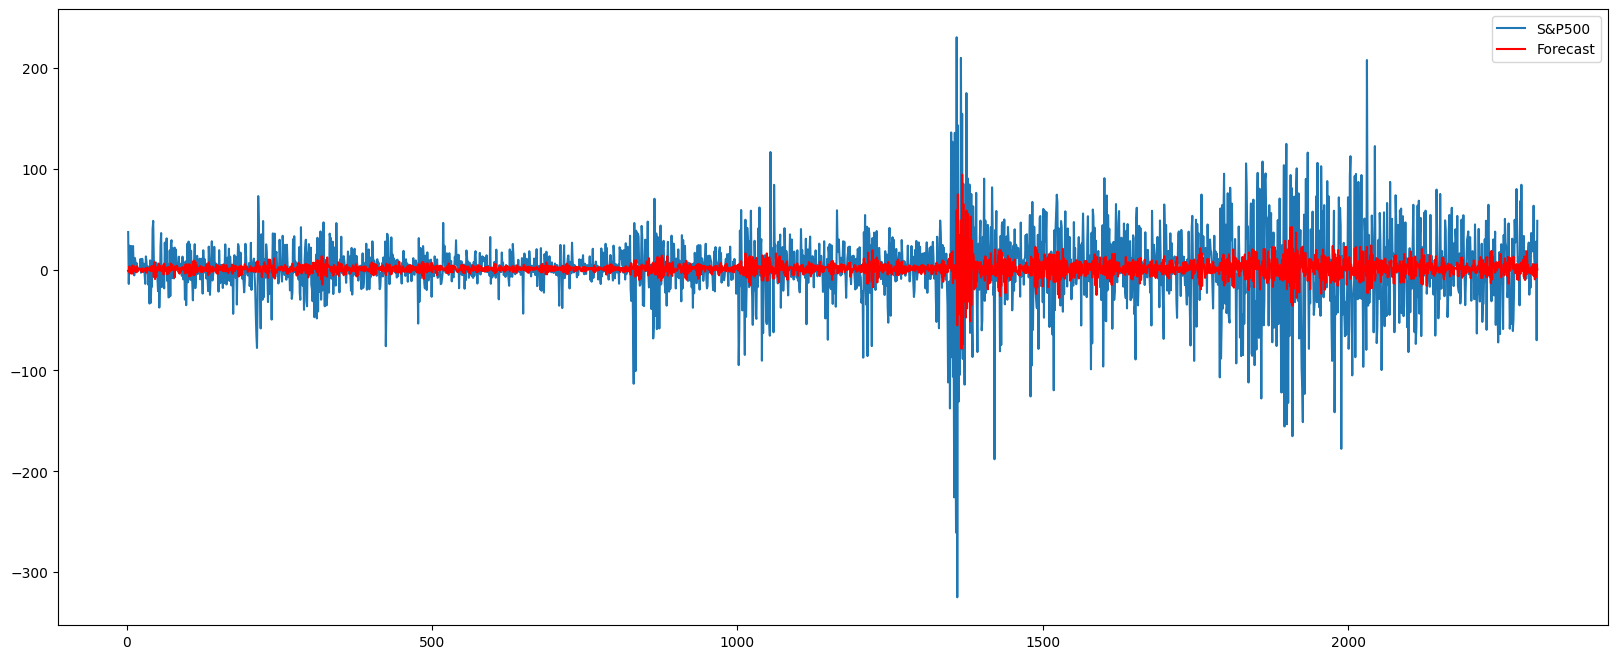

In [27]:
# Fit del modello SARIMA
model = SARIMAX(train_data_dropped['S&P500_diff'], order=(10,0,10), seasonal_order=(2,0,2,22), trend='ct')
results_s = model.fit()

# Visualizza il grafico
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(train_data_dropped['S&P500_diff'][1:])
plt.plot(results_s.fittedvalues[1:], color='red')
ax.legend(['S&P500', 'Forecast'])

# Mostra il sommario dei risultati
print(results_s.summary())

In [29]:
# Test di Ljung-Box sui residui
lb_test = acorr_ljungbox(results_s.resid, lags=[10, 20, 30], return_df=True)
print("Risultati del test di Ljung-Box:")
print(lb_test)

Risultati del test di Ljung-Box:
      lb_stat  lb_pvalue
10   0.086697   1.000000
20   1.104563   1.000000
30  14.577486   0.991918


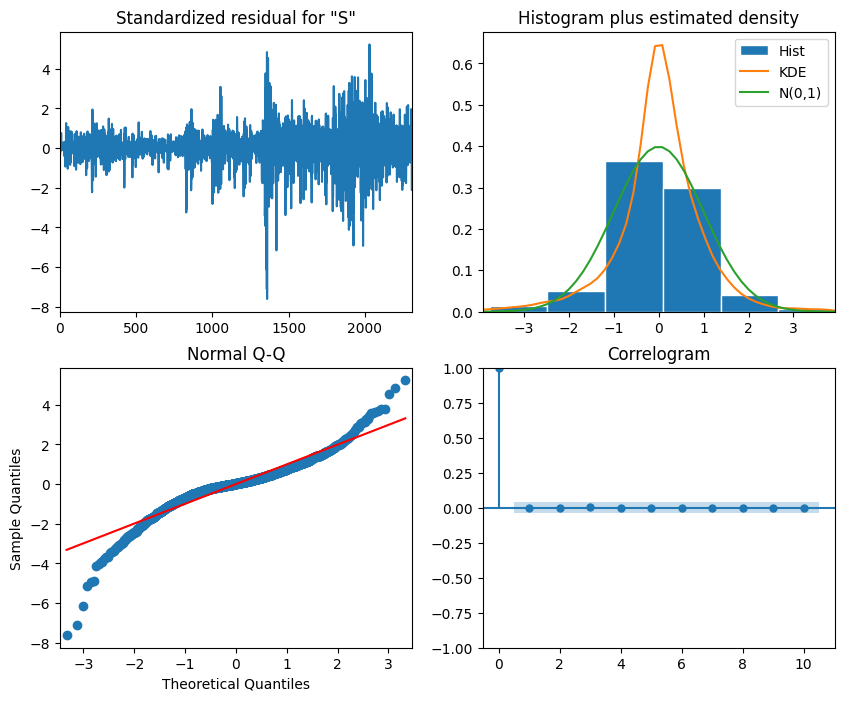

In [30]:
results_s.plot_diagnostics(figsize=(10, 8))
plt.show()

C:\Users\gians_ji5genm\AppData\Local\Temp\ipykernel_23252\2962493057.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['S&P500_diff'] = test_data['S&P500'].diff().dropna()
c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predictio

test_data 2311      NaN
2312    20.12
2313     6.83
2314     1.77
2315   -13.52
        ...  
2511   -11.99
2512    34.98
2513    44.82
2514   -44.59
2515    27.21
Name: S&P500_diff, Length: 205, dtype: float64


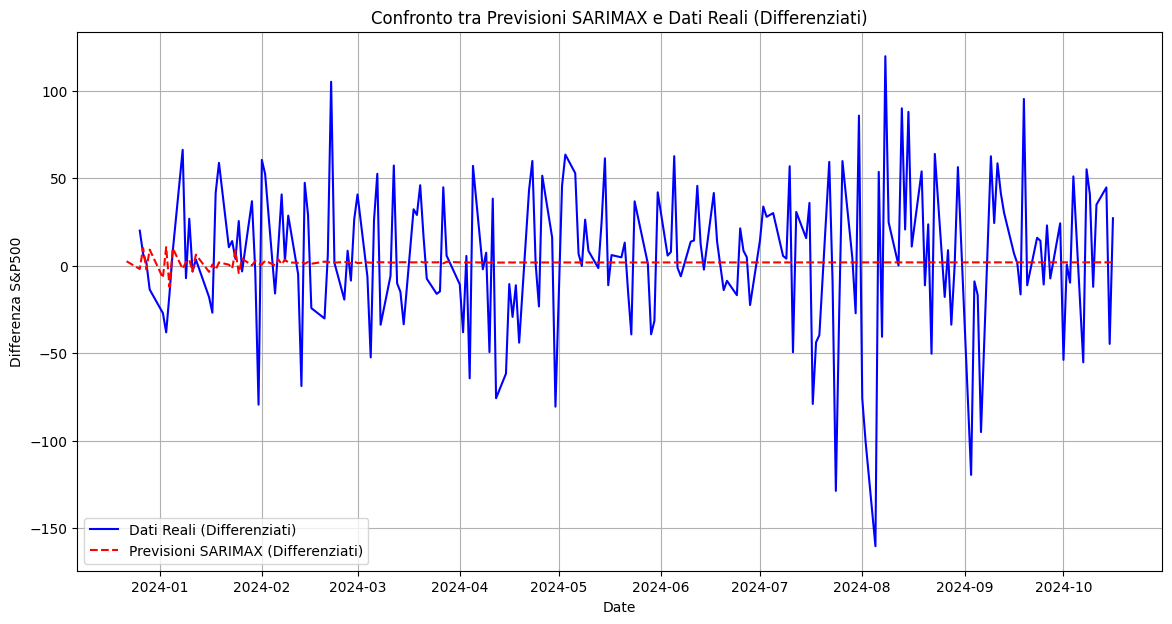

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

test_data['S&P500_diff'] = test_data['S&P500'].diff().dropna()
print('test_data',test_data['S&P500_diff'])


# Fare la previsione con il modello SARIMAX
predictions = results_s.get_forecast(steps=len(test_data['S&P500_diff']))
y_pred = predictions.predicted_mean

y_pred.index = test_data['Date']  # Escludi la prima riga differenziata
y_true = test_data['S&P500_diff']
y_true.index = test_data['Date'] # Escludi la prima riga differenziata


# Step 5: Creazione del grafico
plt.figure(figsize=(14, 7))
plt.plot(y_true, label='Dati Reali (Differenziati)', color='blue')
plt.plot(y_pred, label='Previsioni SARIMAX (Differenziati)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Differenza S&P500')
plt.title('Confronto tra Previsioni SARIMAX e Dati Reali (Differenziati)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\gians_ji5genm\AppData\Local\Temp\ipykernel_23252\214578438.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['S&P500_diff'] = test_data['S&P500'].diff()
c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gians_ji5genm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


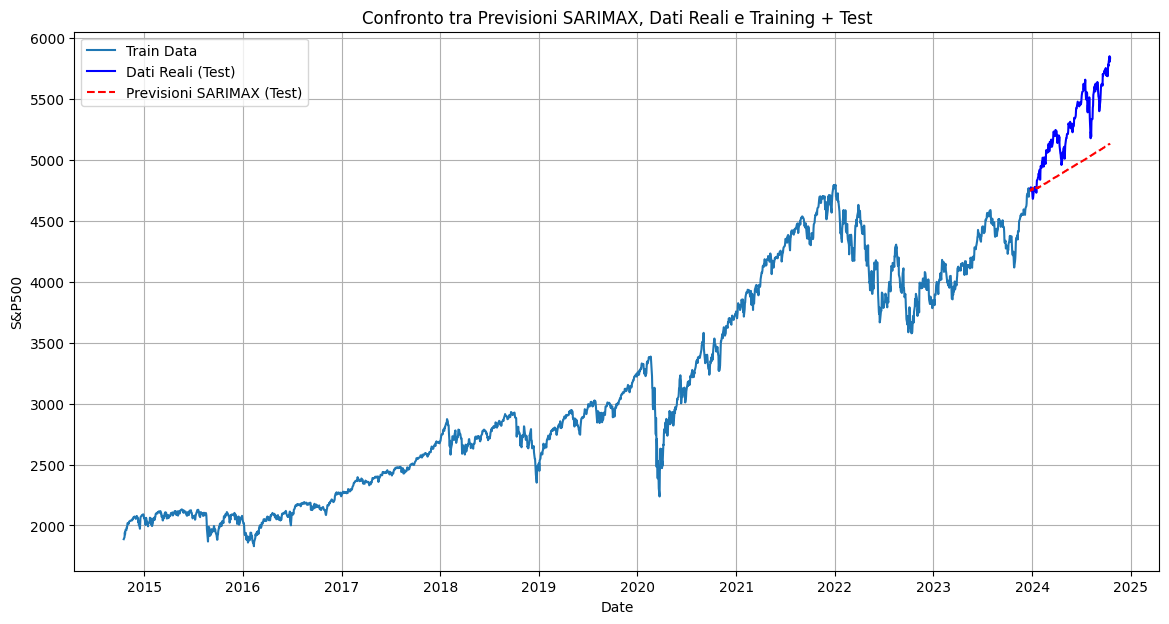

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Differenziazione dei dati di test
test_data['S&P500_diff'] = test_data['S&P500'].diff()

# Step 2: Previsioni con il modello SARIMAX
predictions = results_s.get_forecast(steps=len(test_data['S&P500_diff'].dropna()))
y_pred_diff = predictions.predicted_mean

# Step 3: Ripristinare i dati al dominio originale
last_train_value = train_data['S&P500'].iloc[-1]
y_pred = y_pred_diff.cumsum() + last_train_value

# Ripristinare anche i dati reali
y_true_diff = test_data['S&P500_diff'].dropna()
y_true = y_true_diff.cumsum() + last_train_value

# Allineare l'indice temporale per le previsioni e i dati reali
y_pred.index = test_data['Date'][1:]
y_true.index = test_data['Date'][1:]

# Impostare l'indice temporale per il grafico
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(train_data['S&P500'], label="Train Data")
plt.plot(y_true, label='Dati Reali (Test)', color='blue')
plt.plot(y_pred, label='Previsioni SARIMAX (Test)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.title('Confronto tra Previsioni SARIMAX, Dati Reali e Training + Test')
plt.legend()
plt.grid(True)
plt.show()